In [2]:
%matplotlib inline

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 10)
import numpy as np
import seaborn as sns

# EDA
## Load Data

In [12]:
Posts = pd.read_csv('../../../160-Stackoverflow-Data/300000_rows/Posts.csv', \
                    dtype = {'LastEditorDisplayName': str, 'Tags': str})

## Check NA of Posts

Text(0.5,1,'Posts NA')

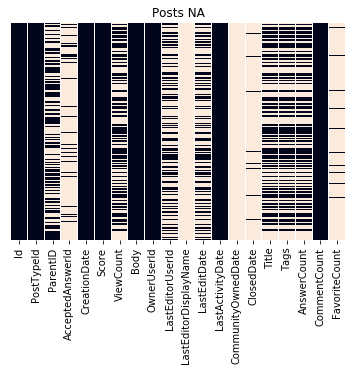

In [14]:
sns.heatmap(Posts.isnull(), yticklabels=False, cbar=False)
plt.title('Posts NA')

In [15]:
Posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299999 entries, 0 to 299998
Data columns (total 20 columns):
Id                       299999 non-null int64
PostTypeId               299999 non-null int64
ParentID                 152190 non-null float64
AcceptedAnswerId         41108 non-null float64
CreationDate             299999 non-null object
Score                    299999 non-null int64
ViewCount                147447 non-null float64
Body                     299813 non-null object
OwnerUserId              299597 non-null float64
LastEditorUserId         115234 non-null float64
LastEditorDisplayName    116 non-null object
LastEditDate             115344 non-null object
LastActivityDate         299999 non-null object
CommunityOwnedDate       239 non-null object
ClosedDate               10922 non-null object
Title                    147447 non-null object
Tags                     147447 non-null object
AnswerCount              147447 non-null float64
CommentCount             29999

# Timely Collaboration and Values
## Answers Posts

In [16]:
import datetime
import calendar

#date to timestamp
def date_ts(s):
    """ 
    param s: str - date
    returns: int - timestamp
    """
    date = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    st = calendar.timegm(date.utctimetuple())
    return(st)

In [17]:
df_answers = Posts[Posts.PostTypeId == 2]

In [18]:
df_answers = df_answers.reset_index(drop=True)

In [19]:
df_answers.CreationDate = df_answers.CreationDate.str[:-4]

In [20]:
unix_ans = [date_ts(i) for i in df_answers.CreationDate]

In [21]:
df_answers_time = pd.DataFrame({'ParentID':df_answers.ParentID, 'Cr_time':unix_ans})

In [22]:
df_list = df_answers_time.groupby(df_answers_time.ParentID)

In [23]:
uni_par_id = list(df_answers_time.ParentID.unique())

In [24]:
ans_date = [list(df_list.get_group(i).Cr_time) for i in uni_par_id]

In [25]:
yes = 0
no = 0
for i in ans_date:
    if len(i) == 1:
        yes += 1
    else:
        no += 1
print(yes, no)

#there are 2917 posts with only 1 answer, 15773 posts with more than 1 answers.

87571 26874


In [26]:
#set 1-answer post sd to 0
for i in ans_date:
    if len(i) == 1:
        i.append(i[0])
    else:
        i == i

In [27]:
import statistics
ans_time_sd = [statistics.stdev(i) for i in ans_date]

In [28]:
post_Id = sorted(list(df_answers.ParentID.unique()))

In [29]:
post_ans_sd = pd.DataFrame({'post_Id':post_Id, 'time_sd':ans_time_sd})

In [30]:
post_ans_sd.head()

,post_Id,time_sd
0,1033.0,0.000000
1,2056.0,0.000000
2,2530.0,0.000000
3,4371.0,33.226495
4,5694.0,337954.962313


## Parents Posts

In [31]:
Parents_post = Posts[Posts.PostTypeId == 1]

In [32]:
Parents_post = Parents_post.reset_index(drop=True)

In [33]:
Parents_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147447 entries, 0 to 147446
Data columns (total 20 columns):
Id                       147447 non-null int64
PostTypeId               147447 non-null int64
ParentID                 0 non-null float64
AcceptedAnswerId         41108 non-null float64
CreationDate             147447 non-null object
Score                    147447 non-null int64
ViewCount                147447 non-null float64
Body                     147447 non-null object
OwnerUserId              147167 non-null float64
LastEditorUserId         73457 non-null float64
LastEditorDisplayName    82 non-null object
LastEditDate             73534 non-null object
LastActivityDate         147447 non-null object
CommunityOwnedDate       0 non-null object
ClosedDate               10922 non-null object
Title                    147447 non-null object
Tags                     147447 non-null object
AnswerCount              147447 non-null float64
CommentCount             147447 non-null

In [34]:
df_parents = pd.DataFrame({'post_Id':Parents_post.Id, 'Views_count':Parents_post.ViewCount,\
                           'Score':Parents_post.Score, 'Comment_count':Parents_post.CommentCount})

In [35]:
df_comb = df_parents.join(post_ans_sd.set_index('post_Id'), on='post_Id')

In [36]:
df_comb.head()

,Comment_count,Score,Views_count,post_Id,time_sd
0,0,1,50.0,48870881,22807.022120
1,0,0,27.0,48870882,2110.006635
2,2,0,27.0,48870886,229137.245336
3,0,1,17.0,48870888,0.000000
4,0,0,19.0,48870890,NaN


## Plots

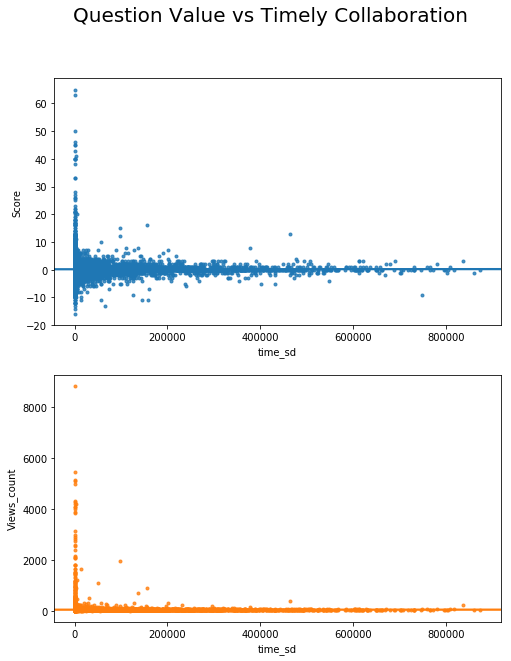

In [37]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, df_comb.Score, marker=".", ax=ax1)
sns.regplot(df_comb.time_sd, df_comb.Views_count, marker=".", ax=ax2)

## Data transformation

In [38]:
df_comb.head()

,Comment_count,Score,Views_count,post_Id,time_sd
0,0,1,50.0,48870881,22807.022120
1,0,0,27.0,48870882,2110.006635
2,2,0,27.0,48870886,229137.245336
3,0,1,17.0,48870888,0.000000
4,0,0,19.0,48870890,NaN


In [39]:
df_comb.Views_count.describe()

count    147447.000000
mean         31.879753
std          60.857818
min           1.000000
25%          18.000000
50%          27.000000
75%          38.000000
max        8821.000000
Name: Views_count, dtype: float64

In [40]:
df_comb.Score.describe()

count    147447.000000
mean         -0.026457
std           1.451993
min         -18.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          65.000000
Name: Score, dtype: float64

In [101]:
import math
def loga(x):
    val = x+abs(min(df_comb.Score))+2
    out = 1/math.log10(val)
    return(out)

In [99]:
_min_score = abs(min(df_comb.Score)) + 2

In [104]:
View_log = df_comb.Views_count.apply(lambda x: 1/math.log10(x + _min_score))

In [103]:
Scores_log = df_comb.Score.apply(lambda x: 1/math.log10(x + _min_score))

In [44]:
yes = 0
no = 0
for i in df_comb.Score:
    if i < 0:
        yes += 1
    else:
        no += 1
print(yes, no)

27233 120214


## Plot of Transformed Data

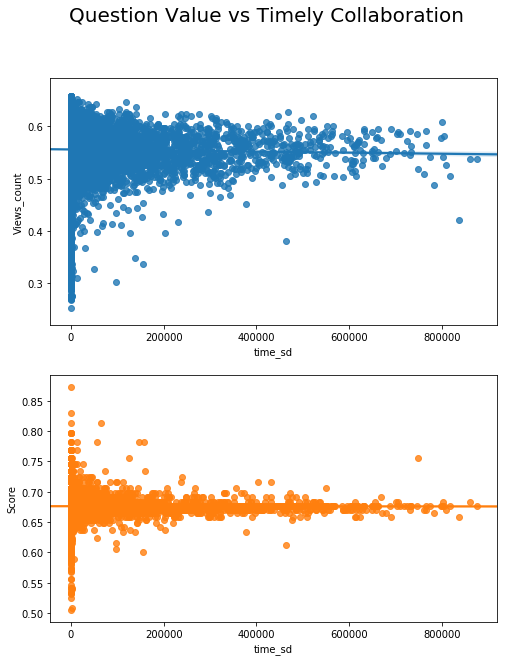

In [45]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, View_log, ax=ax1)
sns.regplot(df_comb.time_sd, Scores_log, ax=ax2)

# Probability of a question being answered as a function of time in minutes
eg. $P(\text{question is answered}|t=0,...,n , n=1,...,1440)$ for 

## Parents Post Data Wrangling

In [46]:
#Parents_post
df_answers

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,48870883,2,48869547.0,NaN,2018-02-19T17:05:50,1,NaN,<p>Try to add hint to the query:</p>\r\n\r\n<p...,8214734.0,8214734.0,NaN,2018-02-20T10:20:21.007,2018-02-20T10:20:21.007,NaN,NaN,NaN,NaN,NaN,2,NaN
1,48870884,2,3865445.0,NaN,2018-02-19T17:05:50,0,NaN,In support of Sean's post:\r\n\r\n<p>The place...,2055283.0,NaN,NaN,NaN,2018-02-19T17:05:50.273,NaN,NaN,NaN,NaN,NaN,0,NaN
2,48870885,2,48870539.0,NaN,2018-02-19T17:05:51,0,NaN,<p>I discovered the convention (couldn't find ...,1052870.0,NaN,NaN,NaN,2018-02-19T17:05:51.300,NaN,NaN,NaN,NaN,NaN,1,NaN
3,48870889,2,48870709.0,NaN,2018-02-19T17:06:01,0,NaN,"<p>Group by the user, then aggregate a list of...",3182843.0,NaN,NaN,NaN,2018-02-19T17:06:01.910,NaN,NaN,NaN,NaN,NaN,0,NaN
4,48870891,2,48870253.0,NaN,2018-02-19T17:06:16,12,NaN,<p>With combination of <code>re.findall()</cod...,3185459.0,3185459.0,NaN,2018-02-19T17:13:55.730,2018-02-19T17:13:55.730,NaN,NaN,NaN,NaN,NaN,8,NaN
5,48870897,2,48870631.0,NaN,2018-02-19T17:06:33,1,NaN,<p>Perhaps it's easiest to just rename the col...,1270695.0,NaN,NaN,NaN,2018-02-19T17:06:33.923,NaN,NaN,NaN,NaN,NaN,4,NaN
6,48870899,2,13830392.0,NaN,2018-02-19T17:06:40,0,NaN,<p>Try this in the terminal:</p>\r\n\r\n<pre><...,7962442.0,NaN,NaN,NaN,2018-02-19T17:06:40.293,NaN,NaN,NaN,NaN,NaN,0,NaN
7,48870900,2,48870828.0,NaN,2018-02-19T17:06:41,1,NaN,<p>What's with the ACF? Why not just </p>\r\n\...,295783.0,NaN,NaN,NaN,2018-02-19T17:06:41.930,NaN,NaN,NaN,NaN,NaN,3,NaN
8,48870902,2,48862416.0,NaN,2018-02-19T17:06:45,2,NaN,<p>The problem is this. You create a lambda a...,3679676.0,3679676.0,NaN,2018-02-19T17:42:45.440,2018-02-19T17:42:45.440,NaN,NaN,NaN,NaN,NaN,1,NaN
9,48870904,2,48870709.0,NaN,2018-02-19T17:06:48,0,NaN,<p>Set up parameters defined by OP</p>\r\n\r\n...,2336654.0,2336654.0,NaN,2018-02-19T17:12:02.800,2018-02-19T17:12:02.800,NaN,NaN,NaN,NaN,NaN,0,NaN


In [47]:
df_answers_time.head()

,Cr_time,ParentID
0,1519059950,48869547.0
1,1519059950,3865445.0
2,1519059951,48870539.0
3,1519059961,48870709.0
4,1519059976,48870253.0


In [48]:
parents_time = Parents_post.CreationDate.str[:-4]

In [49]:
unix_parents = [date_ts(i) for i in parents_time]

In [50]:
df_parents_time = pd.DataFrame({'Cr_time_parents':unix_parents, 'ParentID':Parents_post.Id})

In [51]:
df_parents_time.head()

,Cr_time_parents,ParentID
0,1519059948,48870881
1,1519059949,48870882
2,1519059952,48870886
3,1519059961,48870888
4,1519059966,48870890


## Merge Table & Create Columns of mins and hours

In [52]:
df_compare = pd.merge(df_parents_time, df_answers_time, on='ParentID')

In [53]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time
0,1519059948,48870881,1519060497
1,1519059948,48870881,1519061059
2,1519059949,48870882,1519060388
3,1519059949,48870882,1519060429
4,1519059952,48870886,1519060689


In [54]:
df_compare['Duration'] = df_compare.Cr_time - df_compare.Cr_time_parents

In [55]:
df_compare['Duration_mins'] = df_compare.Duration/60

In [56]:
df_compare['Duration_hours'] = df_compare.Duration_mins/60

In [57]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time,Duration,Duration_mins,Duration_hours
0,1519059948,48870881,1519060497,549,9.150000,0.152500
1,1519059948,48870881,1519061059,1111,18.516667,0.308611
2,1519059949,48870882,1519060388,439,7.316667,0.121944
3,1519059949,48870882,1519060429,480,8.000000,0.133333
4,1519059952,48870886,1519060689,737,12.283333,0.204722


In [58]:
df_compare.Duration_mins.describe()

count    121385.000000
mean        609.633554
std        1971.848971
min           0.000000
25%          11.166667
50%          35.833333
75%         216.283333
max       55468.600000
Name: Duration_mins, dtype: float64

In [59]:
df_compare.Duration_hours.describe()

count    121385.000000
mean         10.160559
std          32.864150
min           0.000000
25%           0.186111
50%           0.597222
75%           3.604722
max         924.476667
Name: Duration_hours, dtype: float64

In [60]:
neg = 0
pos = 0
for i in df_compare.Duration_hours:
    if i >= 0:
        pos += 1
    else:
        neg += 1
print(pos, neg)

#15 negative duration, possibly an error from collecting data
#ie. negative duration means answer being posted before the parents questions being posted (not possible)

121385 0


In [61]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time,Duration,Duration_mins,Duration_hours
0,1519059948,48870881,1519060497,549,9.150000,0.152500
1,1519059948,48870881,1519061059,1111,18.516667,0.308611
2,1519059949,48870882,1519060388,439,7.316667,0.121944
3,1519059949,48870882,1519060429,480,8.000000,0.133333
4,1519059952,48870886,1519060689,737,12.283333,0.204722


## Calculate Frequency and Probability of mins and hours

In [62]:
Duration_mins_rounded = df_compare.Duration_mins.round()

In [63]:
fre_mins = pd.DataFrame(Duration_mins_rounded.value_counts(), index=None)
fre_mins['mins'] = fre_mins.index
fre_mins = fre_mins.rename(columns={'Duration_mins':'Frequency','mins':'mins'})
fre_mins.reset_index(inplace=True, drop=True)
#drop negative mins
fre_mins.drop(fre_mins[fre_mins.mins < 0].index, inplace=True)
fre_mins = fre_mins.sort_values('mins')

In [64]:
fre_mins.head()

,Frequency,mins
56,337,0.0
46,455,1.0
11,2027,2.0
5,3025,3.0
1,3583,4.0


In [65]:
fre_mins['Probabiity'] = fre_mins.Frequency/sum(fre_mins.Frequency)

In [66]:
fre_mins.head()

,Frequency,mins,Probabiity
56,337,0.0,0.002776
46,455,1.0,0.003748
11,2027,2.0,0.016699
5,3025,3.0,0.024921
1,3583,4.0,0.029518


In [67]:
fre_mins.Probabiity.describe()

count    7470.000000
mean        0.000134
std         0.001140
min         0.000008
25%         0.000008
50%         0.000016
75%         0.000033
max         0.029600
Name: Probabiity, dtype: float64

## Plot (Probability)

Text(0.5,1,'Probability of Answered in terms of Minutes')

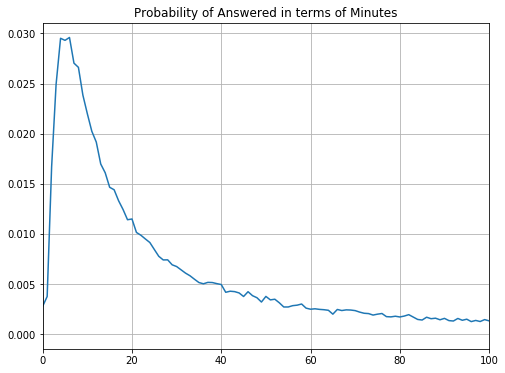

In [68]:
fig=plt.figure(figsize=(8,6))
plt.plot(fre_mins.mins, fre_mins.Probabiity)
plt.xlim(0,100)
plt.grid()
plt.title('Probability of Answered in terms of Minutes')

## Cumulative Probability 

In [69]:
fre_mins.head()

,Frequency,mins,Probabiity
56,337,0.0,0.002776
46,455,1.0,0.003748
11,2027,2.0,0.016699
5,3025,3.0,0.024921
1,3583,4.0,0.029518


In [70]:
fre_mins['cum_pro'] = np.cumsum(list(fre_mins.Probabiity))

In [71]:
fre_mins.head()

,Frequency,mins,Probabiity,cum_pro
56,337,0.0,0.002776,0.002776
46,455,1.0,0.003748,0.006525
11,2027,2.0,0.016699,0.023224
5,3025,3.0,0.024921,0.048144
1,3583,4.0,0.029518,0.077662


Text(0.5,0,'cumulative probability')

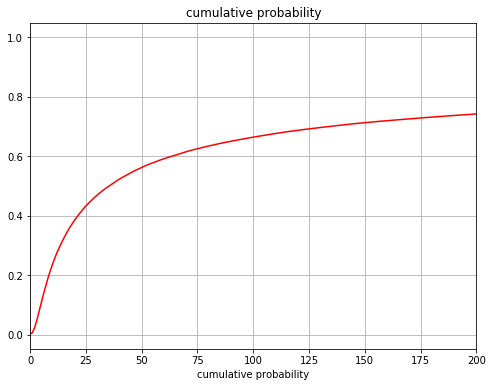

In [72]:
fig=plt.figure(figsize=(8,6))
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,200)
plt.grid()
plt.title('cumulative probability')
plt.xlabel('cumulative probability')

## Summary of Probability Plots

Text(0.5,1,'cumulative probability')

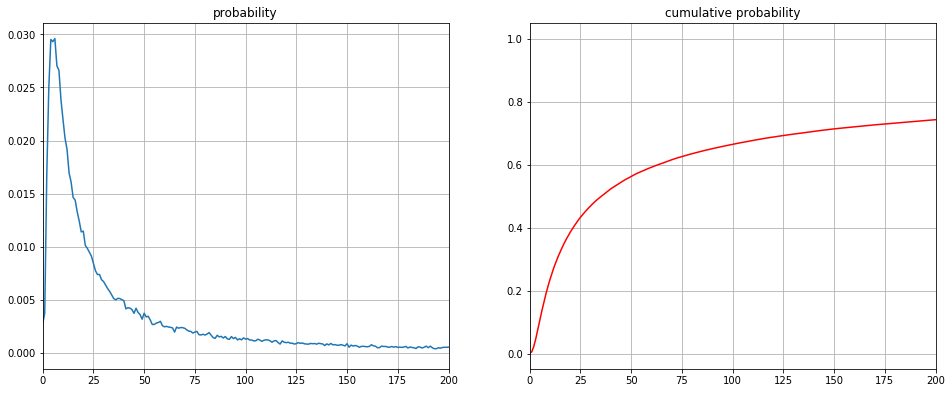

In [73]:
fig=plt.figure(figsize=(16,14))
plt.subplot(221)
plt.plot(fre_mins.mins, fre_mins.Probabiity)
plt.xlim(0,200)
plt.grid()
plt.title('probability')
plt.subplot(222)
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,200)
plt.grid()
plt.title('cumulative probability')

# Similarity

## Load Data

In [74]:
x = ['esmond desmond donia connie','esmond desmond donia connie']
#y = ['my name is duncan and i am a girl from jupyter']
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer().fit_transform(x)

In [75]:
(tf_idf * tf_idf.T).A

array([[ 1.,  1.],
       [ 1.,  1.]])

In [77]:
import json
with open('../../../160-Stackoverflow-Data/300000_rows/graph_dump_load.txt', 'r') as json_file:
    data = json.load(json_file)

In [78]:
data_df = pd.DataFrame.from_dict(data, orient='columns', dtype=None)

In [79]:
data_df = pd.DataFrame.transpose(data_df)

In [80]:
data_df['User.Id'] = data_df.index

In [81]:
data_df.reset_index(inplace=True, drop=True)

In [82]:
data_df.head()

,answers,asks,comments,User.Id
0,"[755369, 177539]",NaN,NaN,1
1,[39879668],[12221770],NaN,1000011
2,NaN,NaN,[385844],10000221
3,NaN,NaN,[820956],10000247
4,[11984163],NaN,NaN,1000030


## Extract Content - Answers

In [83]:
user_ans = pd.DataFrame({'answers':data_df.answers, 'User.Id':data_df['User.Id']})

In [84]:
user_ans = user_ans.dropna()
user_ans = user_ans.reset_index(drop=True)

In [85]:
user_ans.head()

,User.Id,answers
0,1,"[755369, 177539]"
1,1000011,[39879668]
2,1000030,[11984163]
3,1000045,[10055767]
4,1000095,[32768158]


In [86]:
i = 755369
Posts[Posts.Id == i].Body

Series([], Name: Body, dtype: object)

In [87]:
user_ans.answers[0]

[755369, 177539]

In [88]:
user_ans.head()

,User.Id,answers
0,1,"[755369, 177539]"
1,1000011,[39879668]
2,1000030,[11984163]
3,1000045,[10055767]
4,1000095,[32768158]
